# CSC411 Assignment 3
Let's get it.

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

## P1: Reading Data

In [61]:
import os
root_dir = os.path.join(os.getcwd(), "data")
fake_data = pd.read_fwf(os.path.join(root_dir, "clean_fake.txt"), header=None)
real_data = pd.read_fwf(os.path.join(root_dir, "clean_real.txt"), header=None)

In [62]:
print len(fake_data), len(real_data)

1298 1968


In [106]:
fake_train, fake_test = train_test_split(fake_data, test_size=0.15)
real_train, real_test = train_test_split(real_data, test_size=0.15)

fake_train, fake_validation = train_test_split(fake_train, test_size=0.15/0.85)
real_train, real_validation = train_test_split(real_train, test_size=0.15/0.85)

In [107]:
print len(fake_train), len(real_train)

908 1376


## P2: Naive Bayes

In [108]:
def generate_counts(data):
    '''
    data is an array of strings
    '''
    counts = {}
    for line in data:
        words = line.split(" ")
        for word in words:
            if word in counts:
                counts[word] += 1.0
            else:
                counts[word] = 1.0
    return counts

In [112]:
fake_counts = generate_counts(fake_train[0])
real_counts = generate_counts(real_train[0])

fake_vocab = fake_counts.keys()
real_vocab = real_counts.keys()

fake_vocab_size = len(fake_vocab)
print fake_vocab_size
real_vocab_size = len(real_vocab)
print real_vocab_size


for word in fake_counts.keys():
    if word not in real_counts:
        real_counts[word] = 0.0
for word in real_counts.keys():
    if word not in fake_counts:
        fake_counts[word] = 0.0

total_counts = {}
for word in real_counts.keys():
    total_counts[word] = real_counts[word] + fake_counts[word]
    
total_vocab_size = len(total_counts)
print total_vocab_size

num_fake = float(len(fake_train))
num_real = float(len(real_train))
num_total = num_fake + num_real

print num_fake
print num_real

P_real = num_real / num_total
P_fake = num_fake / num_total

print P_real
print P_fake

alpha = 1.0 # Smoothing prior, alpha=1.0 Laplace smoothing
fake_thetas = {word: (fake_counts[word] + alpha) / (num_fake + alpha * fake_vocab_size) for word in fake_counts.keys()}      #gives P(x | fake)
real_thetas = {word: (real_counts[word] + alpha) / (num_real + alpha * real_vocab_size) for word in real_counts.keys()}      #gives P(x | real)
total_thetas = {word: (total_counts[word] + alpha) / (num_total + alpha * total_vocab_size) for word in total_counts.keys()}  #gives P(x)

2968
2961
4783
908.0
1376.0
0.602451838879
0.397548161121


In [113]:
def make_prediction(line):
    '''
    line is a string
    '''
    words = line.split(" ")
    log_P_words_given_real = 0
    log_P_words_given_fake = 0
    for word in real_thetas.keys():
      
        if word in words:
            log_P_words_given_real += np.log(real_thetas[word]) 
            log_P_words_given_fake += np.log(fake_thetas[word])
        else:
            log_P_words_given_real += np.log(1 - real_thetas[word])
            log_P_words_given_fake += np.log(1 - fake_thetas[word])
    
    
    log_numerator = log_P_words_given_real + np.log(P_real)
    numerator = np.exp(log_numerator)
    
    log_fake = log_P_words_given_fake + np.log(P_fake)
    log_denominator = np.log(numerator + np.exp(log_fake))
    
    log_P_real_given_words = log_numerator - log_denominator
    return np.exp(log_P_real_given_words)

In [114]:
print(make_prediction("fcc chairman ajit pai attempted to take a pornstar out for dinner"))

0.284265552377


## Part 3

In [92]:
# Goal: max P(real | word) = max P(word | read) * P(real)
# = max P(word | real) = max real_thetas
real_thetas_ = [(word, theta) for word, theta in real_thetas.items()]
sorted_real_words = sorted(real_thetas_, key=lambda pair: pair[1], reverse=True)
sorted_real_words[:10]

[('trump', 0.28032407407407406),
 ('donald', 0.1337962962962963),
 ('to', 0.07453703703703704),
 ('trumps', 0.0375),
 ('us', 0.03657407407407407),
 ('in', 0.03425925925925926),
 ('on', 0.03125),
 ('of', 0.030787037037037036),
 ('for', 0.02962962962962963),
 ('the', 0.028703703703703703)]

In [93]:
# Goal: max P(real | not word) = max P(not word | read) * P(real)
# = max P(not word | real) = max (1 - P(word | real)) = max (1 - real_thetas)
real_thetas_ = [(word, theta) for word, theta in real_thetas.items()]
sorted_real_words_not = sorted(real_thetas_, key=lambda pair: 1 - pair[1], reverse=True)
sorted_real_words_not[:10]

[('sleep', 0.0002314814814814815),
 ('nwo', 0.0002314814814814815),
 ('assembled', 0.0002314814814814815),
 ('vandal', 0.0002314814814814815),
 ('edward', 0.0002314814814814815),
 ('teaching', 0.0002314814814814815),
 ('sway', 0.0002314814814814815),
 ('divergent', 0.0002314814814814815),
 ('illegally', 0.0002314814814814815),
 ('updated', 0.0002314814814814815)]

In [94]:
# But now look at words that only actually appear in the real headlines
real_thetas_ = [(word, theta) for word, theta in real_thetas.items() if word in real_vocab]
sorted_real_words_not = sorted(real_thetas_, key=lambda pair: 1 - pair[1], reverse=True)
sorted_real_words_not[:10]

[('four', 0.000462962962962963),
 ('island', 0.000462962962962963),
 ('asian', 0.000462962962962963),
 ('aides', 0.000462962962962963),
 ('pheasant', 0.000462962962962963),
 ('hasan', 0.000462962962962963),
 ('marching', 0.000462962962962963),
 ('stinks', 0.000462962962962963),
 ('whose', 0.000462962962962963),
 ('voter', 0.000462962962962963)]

In [95]:
# Goal: max P(fake | word) = max P(word | fake) * P(fake)
# = max P(word | fake) = max fake_thetas
fake_thetas_ = [(word, theta) for word, theta in fake_thetas.items()]
sorted_fake_words = sorted(fake_thetas_, key=lambda pair: pair[1], reverse=True)
sorted_fake_words[:10]

[('trump', 0.23643312101910827),
 ('the', 0.07898089171974522),
 ('to', 0.070828025477707),
 ('donald', 0.041019108280254776),
 ('for', 0.040254777070063696),
 ('in', 0.039235668789808914),
 ('of', 0.03745222929936306),
 ('a', 0.033630573248407646),
 ('and', 0.03337579617834395),
 ('on', 0.02980891719745223)]

In [96]:
# Goal: max P(fake | not word) = max P(not word | fake) * P(fake)
# = max P(not word | fake) = max 1 - fake_thetas
fake_thetas_ = [(word, theta) for word, theta in fake_thetas.items()]
sorted_fake_words_not = sorted(fake_thetas_, key=lambda pair: 1 - pair[1], reverse=True)
sorted_fake_words_not[:10]

[('asian', 0.00025477707006369424),
 ('aides', 0.00025477707006369424),
 ('marching', 0.00025477707006369424),
 ('stinks', 0.00025477707006369424),
 ('whose', 0.00025477707006369424),
 ('paris', 0.00025477707006369424),
 ('nominates', 0.00025477707006369424),
 ('kidman', 0.00025477707006369424),
 ('sorry', 0.00025477707006369424),
 ('whack', 0.00025477707006369424)]

In [98]:
fake_thetas_ = [(word, theta) for word, theta in fake_thetas.items() if word in fake_vocab]
sorted_fake_words_not = sorted(fake_thetas_, key=lambda pair: 1 - pair[1], reverse=True)
sorted_fake_words_not[:10]

[('four', 0.0005095541401273885),
 ('debunks', 0.0005095541401273885),
 ('sleep', 0.0005095541401273885),
 ('deri', 0.0005095541401273885),
 ('liar', 0.0005095541401273885),
 ('nwo', 0.0005095541401273885),
 ('assembled', 0.0005095541401273885),
 ('amtsantritt', 0.0005095541401273885),
 ('teaching', 0.0005095541401273885),
 ('sway', 0.0005095541401273885)]

### Part 3 b)

In [99]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
real_thetas_ = [(word, theta) for word, theta in real_thetas.items() if word not in ENGLISH_STOP_WORDS]
sorted_real_words = sorted(real_thetas_, key=lambda pair: pair[1], reverse=True)
sorted_real_words[:10]

[('trump', 0.28032407407407406),
 ('donald', 0.1337962962962963),
 ('trumps', 0.0375),
 ('says', 0.027777777777777776),
 ('election', 0.015277777777777777),
 ('clinton', 0.01412037037037037),
 ('north', 0.0125),
 ('ban', 0.012268518518518519),
 ('president', 0.011574074074074073),
 ('korea', 0.011574074074074073)]

In [100]:
fake_thetas_ = [(word, theta) for word, theta in fake_thetas.items() if word not in ENGLISH_STOP_WORDS]
sorted_fake_words = sorted(fake_thetas_, key=lambda pair: pair[1], reverse=True)
sorted_fake_words[:10]

[('trump', 0.23643312101910827),
 ('donald', 0.041019108280254776),
 ('hillary', 0.025987261146496816),
 ('clinton', 0.025987261146496816),
 ('election', 0.015286624203821656),
 ('new', 0.012484076433121018),
 ('just', 0.012229299363057325),
 ('win', 0.011210191082802547),
 ('victory', 0.01070063694267516),
 ('america', 0.01019108280254777)]

## Part 7: Decision Tree

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [136]:
sorted_real_words[:30]

[('trump', 0.28032407407407406),
 ('donald', 0.1337962962962963),
 ('trumps', 0.0375),
 ('says', 0.027777777777777776),
 ('election', 0.015277777777777777),
 ('clinton', 0.01412037037037037),
 ('north', 0.0125),
 ('ban', 0.012268518518518519),
 ('president', 0.011574074074074073),
 ('korea', 0.011574074074074073),
 ('white', 0.010185185185185186),
 ('russia', 0.009722222222222222),
 ('turnbull', 0.009259259259259259),
 ('house', 0.009027777777777777),
 ('wall', 0.008796296296296297),
 ('travel', 0.008333333333333333),
 ('deal', 0.007638888888888889),
 ('new', 0.006944444444444444),
 ('obama', 0.006712962962962963),
 ('meeting', 0.00625),
 ('china', 0.0060185185185185185),
 ('australia', 0.0060185185185185185),
 ('tax', 0.005555555555555556),
 ('comey', 0.005324074074074074),
 ('climate', 0.005092592592592593),
 ('comments', 0.004861111111111111),
 ('warns', 0.004629629629629629),
 ('trade', 0.004629629629629629),
 ('win', 0.004629629629629629),
 ('victory', 0.004398148148148148)]

In [200]:
sorted_combined = sorted_real_words[:500] + sorted_fake_words[:500]

In [201]:
important_vocab = list(set([word for word, _ in sorted_combined]))
print(important_vocab)

['wire', 'chinese', 'fox', 'global', 'dollar', 'focus', 'steve', 'roy', 'protest', 'legal', 'controversial', 'talks', 'alt', 'hate', 'soros', 'votes', 'voter', 'praises', 'pardon', 'paris', 'tweet', 'obamacare', 'riots', 'list', 'finally', 'investigation', 'terror', 'adviser', 'woman', 'worse', 'manafort', 'rise', 'results', 'vegas', 'worst', 'fall', 'affect', 'trouble', 'common', 'leads', 'school', 'obstruction', 'did', 'turns', 'sanctions', 'michael', 'leave', 'race', 'denounces', 'polling', 'team', 'deplorable', 'bernie', 'revolution', 'says', 'leaders', 'fence', 'destroys', 'warns', 'sign', '270', 'second', 'street', 'video', 'lawyer', 'machines', 'afghanistan', 'brexit', 'defence', 'power', 'g20', 'asia', 'supporter', 'goes', 'capital', 'corker', 'new', 'public', 'told', 'supporting', 'iran', 'reporter', 'inauguration', 'muslim', 'china', 'address', 'gorafi', '100', 'strong', 'appears', 'change', 'boy', 'great', 'generals', 'daughter', 'ahead', 'withdrawing', 'leaves', 'changed', 

In [202]:
def feature_extraction(titles, important_vocab):
    X = np.zeros([len(titles), len(important_vocab)])
    for i, title in enumerate(titles):
        words = title.split(" ")
        for word in words:
            if word in important_vocab:
                j = important_vocab.index(word)
                X[i,j] += 1
    return X

In [203]:
X_train_fake = feature_extraction(fake_train[0], important_vocab)
X_train_real = feature_extraction(real_train[0], important_vocab)
X_train = np.row_stack((X_train_fake, X_train_real))

y_train_fake = np.zeros([len(fake_train), 1])
y_train_real = np.ones([len(real_train), 1])
y_train = np.row_stack((y_train_fake, y_train_real))


train = np.column_stack((X_train, y_train))
np.random.seed(411)
np.random.shuffle(train)
X_train = train[:,:-1]
y_train = train[:,-1]
print X_train.shape
print y_train.shape

(2284, 814)
(2284,)


In [204]:
X_valid_fake = feature_extraction(fake_validation[0], important_vocab)
X_valid_real = feature_extraction(real_validation[0], important_vocab)
X_valid = np.row_stack((X_valid_fake, X_valid_real))

y_valid_fake = np.zeros([len(fake_validation), 1])
y_valid_real = np.ones([len(real_validation), 1])
y_valid = np.row_stack((y_valid_fake, y_valid_real))


valid = np.column_stack((X_valid, y_valid))
np.random.seed(411)
np.random.shuffle(train)
X_valid = valid[:,:-1]
y_valid = valid[:,-1]
print X_valid.shape
print y_valid.shape

(491, 814)
(491,)


In [205]:
all_depths = []
train_accuracies = []
valid_accuracies = []

In [ ]:
max_depths = np.random.randint(low=1, high=500, size=10)
for depth in max_depths:
    print "Max Depth: {}".format(depth)
    all_depths.append(depth)
    
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train, y_train)
    
    train_accuracy = tree_clf.score(X_train, y_train)
    valid_accuracy = tree_clf.score(X_valid, y_valid)
    
    print "Train Accuracy: {:.4}, Validation Accuracy: {:.4}".format(train_accuracy, valid_accuracy)
    
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

Max Depth: 448
Train Accuracy: 0.9834, Validation Accuracy: 0.7576
Max Depth: 135
Train Accuracy: 0.972, Validation Accuracy: 0.778
Max Depth: 20
Train Accuracy: 0.7842, Validation Accuracy: 0.7149
Max Depth: 307


In [187]:
import matplotlib.pyplot as plt
%matplotlib inline

In [179]:
def plot_accuracies(depths, vocab_size, **accuracies):
    plt.figure(figsize=(12,9))
    plt.title("Training and Validation Accuracies for Various Max Depths\nand a vocab size of {}".format(vocab_size))
    plt.xlabel("Max Depth")
    plt.ylabel("Accuracy")
    for dataset, accuracy in accuracies.items():
        plt.scatter(depths, accuracy, label=dataset, marker='x')
    plt.legend()
    plt.savefig("./figures/accuracies_vocab_size_{}.png".format(vocab_size), dpi=300, bbox_inches='tight')

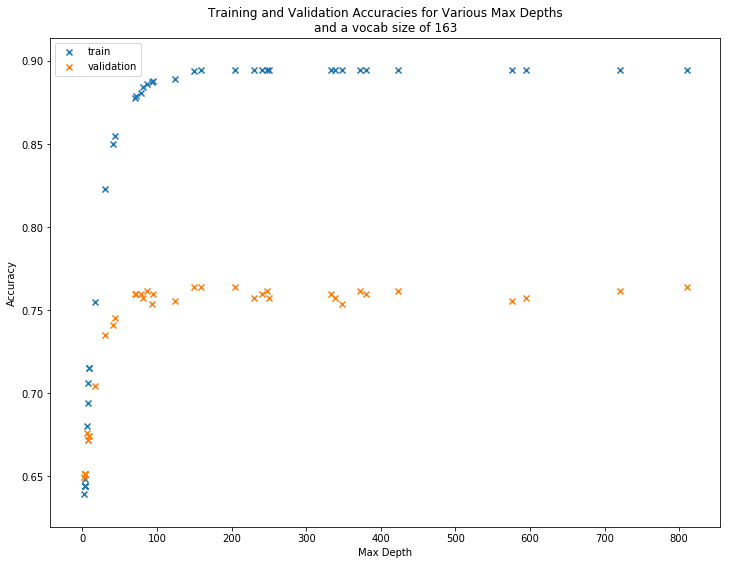

In [199]:
vocab_size = len(important_vocab)
accuracies = {'train': train_accuracies, "validation": valid_accuracies}
plot_accuracies(all_depths, vocab_size, **accuracies)